# Processing and narrating a video with GPT's visual capabilities and the TTS API

This notebook demonstrates how to use GPT's visual capabilities with a video. GPT-4 doesn't take videos as input directly, but we can use vision and the new 128K context window to describe the static frames of a whole video at once. We'll walk through two examples:

1. Using GPT-4 to get a description of a video
2. Generating a voiceover for a video with GPT-4 and the TTS API


In [2]:
from IPython.display import display, Image, Audio

import cv2  # We're using OpenCV to read video, to install !pip install opencv-python
import base64
import time
from openai import OpenAI
import os
import requests

client = OpenAI(api_key="REPLACE WITH API KEY")

## 1. Using GPT's visual capabilities to get a description of a video


First, we use OpenCV to extract frames from a nature [video](https://www.youtube.com/watch?v=kQ_7GtE529M) containing bisons and wolves:


In [3]:
video = cv2.VideoCapture("bison.mp4")

base64Frames = []
while video.isOpened():
    success, frame = video.read()
    if not success:
        break
    _, buffer = cv2.imencode(".jpg", frame)
    base64Frames.append(base64.b64encode(buffer).decode("utf-8"))

video.release()
print(len(base64Frames), "frames read.")

618 frames read.


Display frames to make sure we've read them in correctly:


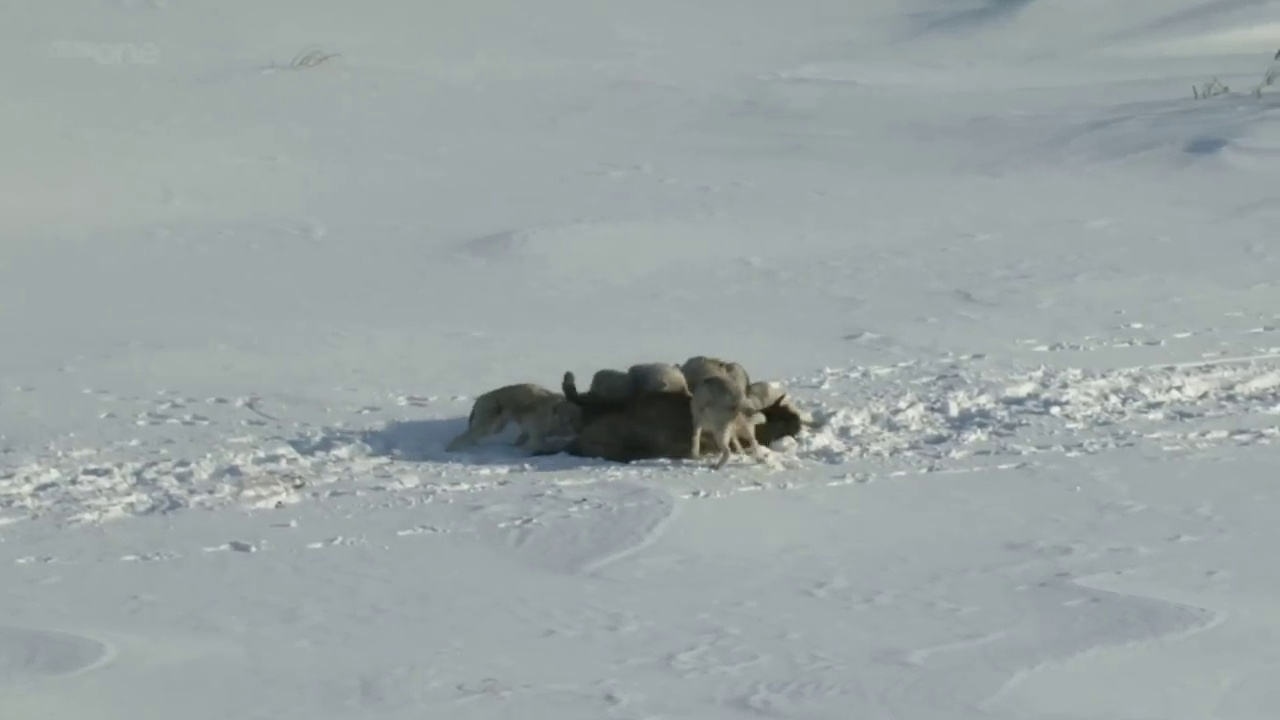

In [4]:
display_handle = display(None, display_id=True)
for img in base64Frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8"))))
    time.sleep(0.025)

Once we have the video frames, we craft our prompt and send a request to GPT (Note that we don't need to send every frame for GPT to understand what's going on):


In [5]:
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            "These are frames from a video that I want to upload. Generate a compelling description that I can upload along with the video.",
            *map(lambda x: {"image": x, "resize": 768}, base64Frames[0::50]),
        ],
    },
]
params = {
    "model": "gpt-4-vision-preview",
    "messages": PROMPT_MESSAGES,
    "max_tokens": 200,
}

result = client.chat.completions.create(**params)
print(result.choices[0].message.content)

"Witness the Raw Power of Nature: A Pack of Wolves Take Down a Bison in the Wild"

Experience the intensity and raw beauty of the natural world with this gripping video showcasing the strategic prowess and cooperative hunting technique of a wolf pack as they challenge a formidable bison in the snowy terrain. This incredible scene captures the harsh realities and unforgiving elements of the wild, where every day is a struggle for survival and only the fittest prevail. Watch as nature unfolds its dramatic play - a true testament to the wild's untamed spirit and the cycle of life. Subscribe for more astounding wildlife encounters and immerse yourself in the wonder of nature's unscripted drama.

#NatureIsWild #WolfPackHunt #BisonBattle #WildlifeSurvival #PredatorPreyDynamics #NatureDocumentary

(Note: Please ensure that the video content adheres to appropriate platform guidelines and does not promote cruelty or exploitation of animals.)


## 2. Generating a voiceover for a video with GPT-4 and the TTS API


Let's create a voiceover for this video in the style of David Attenborough. Using the same video frames we prompt GPT to give us a short script:


In [6]:
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            "These are frames of a video. Create a short voiceover script in the style of David Attenborough. Only include the narration.",
            *map(lambda x: {"image": x, "resize": 768}, base64Frames[0::60]),
        ],
    },
]
params = {
    "model": "gpt-4-vision-preview",
    "messages": PROMPT_MESSAGES,
    "max_tokens": 500,
}

result = client.chat.completions.create(**params)
print(result.choices[0].message.content)

In the unforgiving expanse of the arctic tundra, a relentless dance of life and death unfolds. Here we see a pack of grey wolves, the storied predators of the north, coordinating an attack on a vastly larger but solitary bison. Each wolf, finely tuned by the forces of evolution, is a testament to cunning and endurance.

The bison, though formidable, is at a disadvantage. Outflanked and outnumbered, it must fend off adversaries from every direction. This ancient ritual is as much about strategy as it is about strength. The wolves nimbly dart in and out, weariness is their ally just as much as their sharp fangs.

We witness a primal ballet — a lithe and agile pack against the brute force of one. It's a harsh reminder that in these icy realms, survival is never certain, and every moment of life is fiercely contested.

As the bison succumbs to the unyielding assault, the wolves ensure the survival of their pack. In the savage beauty of nature, every ending fuels a new beginning. The cycle 

Now we can pass the script to the TTS API where it will generate an mp3 of the voiceover:


In [8]:
response = requests.post(
    "https://api.openai.com/v1/audio/speech",
    headers={
        "Authorization": f"Bearer REPLACE WITH API KEY",
    },
    json={
        "model": "tts-1-1106",
        "input": result.choices[0].message.content,
        "voice": "onyx",
    },
)

audio = b""
for chunk in response.iter_content(chunk_size=1024 * 1024):
    audio += chunk
Audio(audio)